calib_good/calib95.jpg


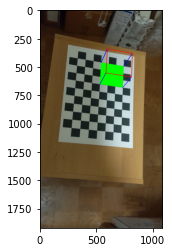

calib_good/calib14.jpg


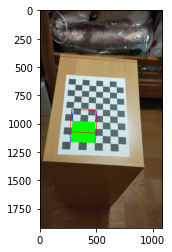

calib_good/calib24.jpg


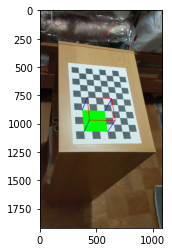

In [60]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


def draw(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)
    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -3)
    # draw pillars in blue color
    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)
    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)
    return img


criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# ワールド座標系におけるキャリブレーションボードの各点の座標
objp = np.zeros((7*10,3), np.float32)
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)

# 推定した位置姿勢を分かりやすく可視化するための仮想的な物体
cube = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                   [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3]])

# キャリブレーションで推定した単一カメラの内部パラメータ
mtx, dist = np.load("camera/mtx.npy"), np.load("camera/dist.npy")

# 画像に写っている物体の位置姿勢を推定
for fname in glob.glob('calib_good/*.jpg')[::4]:
    print(fname)

    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # キャリブレーションボードの位置姿勢を推定してみます
    ret, corners = cv2.findChessboardCorners(gray, (10,7), None)  ## 数注意!

    if ret == True:
        # 座標の精度を上げる
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)

        # solvePnP を用いて外部パラメータ (物体の位置姿勢に相当) だけを推定します。
        err, rvec, tvec = cv2.solvePnP(objp, corners2, mtx, dist)

        # 推定結果を可視化するために、物体 cube を画像に投影してみます。
        imgpts, jac = cv2.projectPoints(cube, rvec, tvec, mtx, dist)
        img = draw(img, imgpts)

        plt.imshow(img[...,::-1]); plt.show()

In [61]:
imgpoint, objpoint = corners2[-1][0], objp[-1]
imgx, imgy = int(imgpoint[0]), int(imgpoint[1])
print(imgpoint, objpoint)

[695.514   585.00287] [9. 6. 0.]


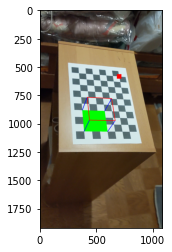

In [62]:
img[imgy-20:imgy+20, imgx-20:imgx+20, 0:2] = 0
img[imgy-20:imgy+20, imgx-20:imgx+20, 2] = 255
plt.imshow(img[...,::-1]); plt.show()

In [63]:
# 世界座標 -> 画像座標
def world2cam(w_pos, rvec, tvec, mtx, dist):
    assert len(w_pos.shape) == 1
    w_pos = w_pos[np.newaxis, :]

    fx, fy, cx, cy = mtx[0,0], mtx[1,1], mtx[0,2], mtx[1,2]
    k1, k2, p1, p2 = dist[0,:4]
    R, _ = cv2.Rodrigues(rvec.squeeze())

    xyz = np.dot(R, w_pos.T) + tvec
    x, y, z = xyz[:,0]

    x_ = x / z
    y_ = y / z

    # easy ver
    # u = fx * x_ + cx
    # v = fy * y_ + cy

    r2 = x_ ** 2 + y_ ** 2
    r4 = r2 ** 2
    x__ = x_ * (1 + k1*r2 + k2*r4) + 2*p1*x_*y_ + p2*(r2 + 2*x_**2)
    y__ = y_ * (1 + k1*r2 + k2*r4) + 2*p2*x_*y_ + p1*(r2 + 2*y_**2)
    u = fx * x__ + cx
    v = fy * y__ + cy
    uv = np.array([u, v])

#     uv1 = np.dot(mtx, xyz)
#     print(uv1)

    return uv, z

uv, z = world2cam(objpoint, rvec, tvec, mtx, dist)
print("w: {} -> c: {}".format(objpoint, uv))

w: [9. 6. 0.] -> c: [695.54650279 585.13131133]


In [81]:
# 画像座標 -> 世界座標
def cam2world(c_pos, rvec, tvec, mtx, dist, z):
    assert len(c_pos.shape) == 1

    fx, fy, cx, cy = mtx[0,0], mtx[1,1], mtx[0,2], mtx[1,2]
    k1, k2, p1, p2 = dist[0,:4]
    R, _ = cv2.Rodrigues(rvec.squeeze())

    u, v = c_pos
    x_ = (u - cx) / fx
    y_ = (v - cy) / fy
    x = x_ * z
    y = y_ * z

    xyz = np.array([[x], [y], [z]])
    xyz = np.dot(R.T, xyz - tvec)  # np.dot(R.T,R) = I
    xyz = xyz.squeeze()

    return xyz

c_pos = corners2[0][0]
xyz = cam2world(c_pos, rvec, tvec, mtx, dist, z)
print("c: {} (z(カメラとの距離)は1???)-> w: {}".format(c_pos, xyz))

c: [ 387.43295 1068.3589 ] (z(カメラとの距離)は1???)-> w: [2.31781506 1.18930299 5.06530469]


In [76]:
c_pos = corners2[0][0]
xyz = cam2world(c_pos, rvec, tvec, mtx, dist, z)
print("c: {} (z(カメラとの距離)は1???)-> w: {}".format(c_pos, xyz))
print(objp[0])

c: [ 387.43295 1068.3589 ] (z(カメラとの距離)は1???)-> w: [2.31781506 1.18930299 5.06530469]
[0. 0. 0.]


In [73]:
c_pos = corners2[8][0]
xyz = cam2world(c_pos, rvec, tvec, mtx, dist, z)
print("c: {} (z(カメラとの距離)は1???)-> w: {}".format(c_pos, xyz))

c: [346.29572 606.31036] (z(カメラとの距離)は1???)-> w: [9.39648518 0.36074699 1.64093649]


In [49]:
xyz = cam2world(np.array([img.shape[1] / 2, img.shape[0] / 2]), rvec, tvec, mtx, dist, z)
print(xyz)  # 画像中心の座標が出ただけ

[3.67437671 3.63420101 3.55584578]


In [78]:
for i in range(70):
    c_pos = corners2[i][0]
    xyz = cam2world(c_pos, rvec, tvec, mtx, dist, z)
    print("c: {} (z(カメラとの距離)は1???)-> w: {}".format(c_pos, xyz))

c: [ 387.43295 1068.3589 ] (z(カメラとの距離)は1???)-> w: [2.31781506 1.18930299 5.06530469]
c: [ 381.92288 1003.856  ] (z(カメラとの距離)は1???)-> w: [3.30557559 1.07742206 4.58624265]
c: [376.4305  942.20526] (z(カメラとの距離)は1???)-> w: [4.25008324 0.96681218 4.12934708]
c: [371.17444 882.224  ] (z(カメラとの距離)は1???)-> w: [5.1688499  0.86062226 3.68444287]
c: [366.0092  823.67096] (z(カメラとの距離)は1???)-> w: [6.06580391 0.75640226 3.25028184]
c: [360.5777 767.2747] (z(カメラとの距離)は1???)-> w: [6.9305728  0.64859405 2.83410099]
c: [355.4479 712.1654] (z(カメラとの距離)は1???)-> w: [7.77527562 0.54613798 2.42664308]
c: [350.6184  658.37933] (z(カメラとの距離)は1???)-> w: [8.59936468 0.44902373 2.02819744]
c: [346.29572 606.31036] (z(カメラとの距離)は1???)-> w: [9.39648518 0.36074699 1.64093649]
c: [341.7201  556.09393] (z(カメラとの距離)は1???)-> w: [10.16600631  0.26899365  1.26922486]
c: [ 457.64807 1069.3529 ] (z(カメラとの距離)は1???)-> w: [2.17137375 2.33203691 4.76729726]
c: [ 450.95517 1005.6675 ] (z(カメラとの距離)は1???)-> w: [3.14896024 2.20119323 4.2997612